In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch as nn

## Simulation Setup

### TOU

In [2]:
TOU = np.array([0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 
                0.06, 0.06, 0.12, 0.14, 0.14, 0.12,
                0.14, 0.14, 0.14, 0.14, 0.12, 0.12,
                0.12, 0.12, 0.12, 0.12, 0.06, 0.06,                      
                ])

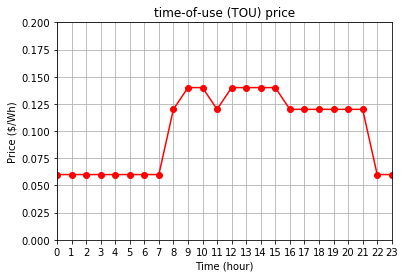

In [3]:
plt.plot(TOU, 'r-o')

plt.xlim(0,23)
plt.ylim(0, 0.2)

plt.xticks(np.arange(24))

plt.title("time-of-use (TOU) price")
plt.xlabel("Time (hour)")
plt.ylabel("Price ($/Wh)")

plt.grid(True)
plt.show()

### PV system (deterministic)

In [4]:
pv_system = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 250, 
                      500, 1000, 1400, 1750, 2000, 1750,
                      1400, 1000, 500, 250, 0.0, 0.0,
                      0.0, 0.0, 0.0, 0.0, 0.0, 0.0                    
                     ])

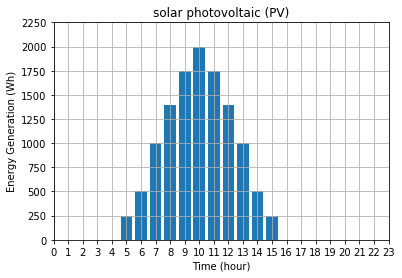

In [5]:
plt.bar(np.arange(24), pv_system)

plt.xlim(0,23)
plt.ylim(0, 2250)

plt.xticks(np.arange(24))

plt.title("solar photovoltaic (PV)")
plt.xlabel("Time (hour)")
plt.ylabel("Energy Generation (Wh)")

plt.grid(True)
plt.show()

### Outdoor Temperature (deterministic)

In [6]:
outdoor_temperature = np.array([23, 23, 23, 23, 24, 24, 
                                27, 28, 28, 31, 31, 32,
                                33, 33, 32, 32, 30, 30,
                                29, 27, 27, 26, 25, 24                    
                                ])

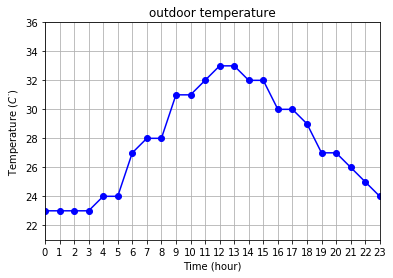

In [27]:
plt.plot(outdoor_temperature, 'b-o')

plt.xlim(0,23)
plt.ylim(21, 36)

plt.xticks(np.arange(24))

plt.title("outdoor temperature")
plt.xlabel("Time (hour)")
plt.ylabel("Temperature ($C^{\cdot}$)")

plt.grid(True)
plt.show()

## Formulation of RL and ANN-Based Home Energy Management

### [State]

#### WM (Washing Machine)

$$ \mathcal{S}^{\mathrm{WM}}=\left\{E_{t}^{\mathrm{WM}}\right\} , \quad \forall t=1, \ldots, 24 $$ 

#### AC (air conditioner)

$$ \mathcal{S}^{\mathrm{AC}}=\left\{E_{t}^{\mathrm{AC}}\right\} , \quad \forall t=1, \ldots, 24 $$ 

#### ESS (energy storage system)

$$
\mathcal{S}^{\mathrm{ESS}}=\left\{S O E_{t}^{\mathrm{ESS}}\right\}, \quad \forall t=1, \ldots, 24
$$

### [Action]

#### WM (Washing Machine)

$$
\begin{aligned}
\mathcal{A}^{\mathrm{WM}} &=\{\mathrm{On}, \mathrm{Off}\}
\end{aligned}
$$

#### AC (air conditioner)

$$
\begin{aligned}
\mathcal{A}^{\mathrm{AC}} &=\left\{0, \Delta E^{\mathrm{AC}}, 2 \Delta E^{\mathrm{AC}}, \ldots, 8 \Delta E^{\mathrm{AC}}, 9 \Delta E^{\mathrm{AC}}\right\}
\end{aligned}
$$

#### ESS (energy storage system)

$$
\begin{aligned}
\mathcal{A}^{\mathrm{ESS}} &=\left\{-4 \Delta E^{\mathrm{ESS}},-3 \Delta E^{\mathrm{ESS}},-2 \Delta E^{\mathrm{ESS}},-1 \Delta E^{\mathrm{ESS}}, 0,1 \Delta E^{\mathrm{ESS}}, 2 \Delta E^{\mathrm{ESS}}, 3 \Delta E^{\mathrm{ESS}}, 4 \Delta E^{\mathrm{ESS}}\right\}
\end{aligned}
$$

### [Reward]

$$ r^{\text{Total}} = r_t^{\text{WM}} + r_t^{\text{AC}} + r_t^{\text{ESS}}$$

#### WM (Washing Machine)

- $\pi_{t}$ : TOU price at time slot $t$
- $E_{t}^{WM}$ : the energy consumption of the WM at time slot $t$
- $\omega_{s}^{\text{pref}}$ : the consumer preferred starting times of WM
- $\omega_{f}^{\text{pref}}$ : the consumer preferred  finishing times of WM
- $\overline{\delta}$ : the penalties for early operation of WM
- $\underline{\delta}$ : the penalties for late operation of WM


$$ 
r_{t}^{\mathrm{WM}}=\left\{\begin{array}{ll}
-\left[\pi_{t} E_{t}^{\mathrm{WM}}+\bar{\delta}\left(\omega_{s}^{\text {pref}}-t\right)\right], & \text { if } t<\omega_{s}^{\text {pref}} \\
-\left[\pi_{t} E_{t}^{\mathrm{WM}}+\underline{\delta}\left(t-\omega_{f}^{\text {pref}}\right)\right], & \text { if } t>\omega_{f}^{\text {pref}} \\
-\pi_{t} E_{t}^{\mathrm{WM}}, & \text { otherwise }
\end{array}\right. \tag{26}\label{26}
$$

#### AC (air conditioner)

- $\pi_{t}$ : TOU price at time slot $t$
- $E_{t}^{AC}$ : the energy consumption of the AC at time slot $t$
- $T^{min}$ : the consumer preferred min temperature : (23)
- $T^{max}$ : the consumer preferred max temperature : (25)
- $T_{t}^{in}$ : in-door temperature
- $\kappa$ : the penalty for the consumer thermal discomfort : (10, 50, 100)

$$
r_{t}^{\mathrm{AC}}=\left\{\begin{array}{ll}
-\left[\pi_{t} E_{t}^{\mathrm{AC}}+\kappa\left(T^{\min }-T_{t}^{\mathrm{in}}\right)\right], & \text { if } T_{t}^{\mathrm{in}}<T^{\mathrm{min}} \\
-\left[\pi_{t} E_{t}^{\mathrm{AC}}+\kappa\left(T_{t}^{\mathrm{in}}-T^{\max }\right)\right], & \text { if } T_{t}^{\mathrm{in}}>T^{\mathrm{max}} \\
-\pi_{t} E_{t}^{\mathrm{AC}}, & \text { otherwise }
\end{array}\right. \tag{27}\label{27}
$$

#### ESS (energy storage system)

- $\pi_{t}$ : TOU price at time slot $t$
- $E_{t}^{ESS}$ : the energy consumption of the ESS at time slot $t$
- $SOE_t$ : State of energy of ESS at time slot $t$
- $SOE^{max}$ : Maximum state of energy of ESS
- $SOE^{min}$ : Minimum state of energy of ESS
- $\overline{\tau}$ : the penalties for overcharging of ESS
- $\underline{\tau}$ : the penalties for undercharging of ESS


$$
r_{t}^{\mathrm{ESS}}=\left\{\begin{array}{ll}
-\left[\pi_{t} E_{t}^{\mathrm{ESS}}+\bar{\tau}\left(S O E_{t}-S O E^{\max }\right)\right], & \text { if } S O E_{t}>S O E^{\max } \\
-\left[\pi_{t} E_{t}^{\mathrm{ESS}}+\underline{\tau}\left(S O E^{\mathrm{min}}-S O E_{t}\right)\right], & \text { if } S O E_{t}<S O E^{\mathrm{min}} \\
-\pi_{l} E_{t}^{\mathrm{ESS}}, & \text { otherwise }
\end{array}\right. \tag{28}\label{28}
$$

In [219]:
# A task/simulation which needs to be solved by the Agent.
class Environments():
    """
    가전기기 환경
    """
    
    def __init__(self, state_dim=24):
        # State Space (the energy consumption of time unit)
        self.state_dim = state_dim
        self.AC_states = np.array([0]*self.state_dim) # WM agent performs the binary action
        self.WM_states = np.array([0]*self.state_dim)
        self.ESS_states = np.array([0]*self.state_dim)
        
        # TOU
        self.TOU = np.array([0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 
                             0.06, 0.06, 0.12, 0.14, 0.14, 0.12,
                             0.14, 0.14, 0.14, 0.14, 0.12, 0.12,
                             0.12, 0.12, 0.12, 0.12, 0.06, 0.06,                      
                             ])
        
        # PV
        self.pv_system = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 250, 
                                   500, 1000, 1400, 1750, 2000, 1750,
                                   1400, 1000, 500, 250, 0.0, 0.0,
                                   0.0, 0.0, 0.0, 0.0, 0.0, 0.0                    
                                  ])
        
    def reset(self):
        """ Environment states reset
        Args:
            None
        Returns:
            state  
        """
        self.AC_states = np.array([0]*self.state_dim)
        self.WM_states = np.array([0]*self.state_dim)
        self.ESS_states = np.array([0]*self.state_dim)
        
        return self.WM_states
        
    def step(self, time, action):
        """ 

        Args:
            time : 0~23까지의 시간
            action : action
        Returns:
            next_state, reward, done
        """
        
        reward = self.WM_step(time, action)
        
#         reward = AC_reward(actions[0]) + WM_reward(actions[1]) + ESS_reward(actions[2])
        # state = [self.AC_states, self.WM_states, self.ESS_states]

        if time == 23:
            done = True
            next_state = None
        else :
            done = False
            next_state = self.WM_states[time+1]
            
        return next_state, reward, done
        
        
    def WM_step(self, time, action, WM_pref = [6, 22]):
        """
        Args:
            time : 시간
            action : 행동
            WM_pref :선호 시간 [시작, 종료]
            
        Returns:
            reward
        """
        # 세타긱 소비전력 (e.g. 500W)
        WM_power = 500
        # penalty
        early_penalty = 50
        late_penalty = 50

        start_time = time
        end_time = time + 1
        
        reward = 0
        
        if action == 1:
            
            self.WM_states[time] = WM_power
            
            if start_time < WM_pref[0]:
                reward = -(self.TOU[start_time] * WM_power + early_penalty*(WM_pref[0]-start_time))
            elif end_time > WM_pref[1]:
                reward = -(self.TOU[start_time] * WM_power + late_penalty*(end_time - WM_pref[1]))
            else:
                reward = -(self.TOU[start_time] * WM_power)
            
            return reward
            
        else :
            
            self.WM_states[time] = 0
            
            return reward
        
    def AC_reward(self, time, action, temp_in, temp_pref=[23, 25]):
        """
        Args:
            time : 시간
            action : 행동
            temp_in : 실내 온도 (ANN 으로 부터 추정)
            temp_pref :선호 온도 [최저, 최대]
            
        Returns:
            reward
        """
        # the penalty for the consumer thermal discomfort
        kappa = 50
        
        self.AC_states[time] = action
        
        if temp_in < temp_pref[0]:
            reward = - (self.TOU[time]*action + kappa*(temp_pref[0]-temp_in))
        
        elif temp_in > temp_pref[1]:
            reward = - (self.TOU[time]*action + kappa*(temp_in-temp_pref[1]))
        else :
            reward = self.TOU[time]*action
            
        return reward
    
    def ESS_reward(self, time, action, min_max_SOE = [800, 4000]):
        """
        Args:
            time : 시간
            action : 행동
            min_max_ESS :minimum, and maximum SOE values [최소, 최대]
            
        Returns:
            reward
        """
        # the penalties for the ESS overcharging and undercharging
        overcharging_penalty = 50
        undercharging_penalty = 50
        
        self.ESS_states[time] += self.pv_system[time] + action
        temp_SOE = self.ESS_states[time]
        
        if temp_SOE > min_max_SOE[1]:
            reward = - (self.TOU[time]*action + overcharging_penalty*(temp_SOE-min_max_SOE[1]))
        
        elif temp_SOE < min_max_SOE[0]:
            reward = - (self.TOU[time]*action + undercharging_penalty*(min_max_SOE[0]-temp_SOE))
            
        else :
            reward = self.TOU[time]*action
            
        return reward

In [197]:
# test
env = Environments()

In [189]:
print(len(env.WM_states))
print(env.WM_states)

24
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [161]:
env.WM_step(time=1, action=1)

-280.0

In [162]:
case_1 = np.array([0]*5 + [1]*2 + [0]*17)
case_2 = np.array([0]*12 + [1]*2 + [0]*10)
case_3 = np.array([0]*21 + [1]*2 + [0]*1)
case_4 = np.array([0]*23 + [1]*1) # 23시에 시작하는 경우는 ? 어떻게 해야할지.

In [163]:
# WM 의 reward 검증
for time, action in enumerate(case_1):
    print("Reward of WM at {} hour : {}".format(time, env.WM_step(time=time, action=action))) 

Reward of WM at 0 hour : 0
Reward of WM at 1 hour : 0
Reward of WM at 2 hour : 0
Reward of WM at 3 hour : 0
Reward of WM at 4 hour : 0
Reward of WM at 5 hour : -80.0
Reward of WM at 6 hour : -30.0
Reward of WM at 7 hour : 0
Reward of WM at 8 hour : 0
Reward of WM at 9 hour : 0
Reward of WM at 10 hour : 0
Reward of WM at 11 hour : 0
Reward of WM at 12 hour : 0
Reward of WM at 13 hour : 0
Reward of WM at 14 hour : 0
Reward of WM at 15 hour : 0
Reward of WM at 16 hour : 0
Reward of WM at 17 hour : 0
Reward of WM at 18 hour : 0
Reward of WM at 19 hour : 0
Reward of WM at 20 hour : 0
Reward of WM at 21 hour : 0
Reward of WM at 22 hour : 0
Reward of WM at 23 hour : 0


In [167]:
# WM 의 reward 검증
# (next_state, reward, done)
for time, action in enumerate(scenario_1):
    print("Reward of WM at {} hour : {}".format(time, env.step(time=time, action=action)))

Reward of WM at 0 hour : (0, 0, False)
Reward of WM at 1 hour : (0, 0, False)
Reward of WM at 2 hour : (0, 0, False)
Reward of WM at 3 hour : (0, 0, False)
Reward of WM at 4 hour : (500, 0, False)
Reward of WM at 5 hour : (500, -80.0, False)
Reward of WM at 6 hour : (0, -30.0, False)
Reward of WM at 7 hour : (0, 0, False)
Reward of WM at 8 hour : (0, 0, False)
Reward of WM at 9 hour : (0, 0, False)
Reward of WM at 10 hour : (0, 0, False)
Reward of WM at 11 hour : (0, 0, False)
Reward of WM at 12 hour : (0, 0, False)
Reward of WM at 13 hour : (0, 0, False)
Reward of WM at 14 hour : (0, 0, False)
Reward of WM at 15 hour : (0, 0, False)
Reward of WM at 16 hour : (0, 0, False)
Reward of WM at 17 hour : (0, 0, False)
Reward of WM at 18 hour : (0, 0, False)
Reward of WM at 19 hour : (0, 0, False)
Reward of WM at 20 hour : (0, 0, False)
Reward of WM at 21 hour : (0, 0, False)
Reward of WM at 22 hour : (0, 0, False)
Reward of WM at 23 hour : (None, 0, True)


## Agent 구현 및 학습

In [218]:
class QLearning_Agent():
    """
    가전기기 Agent
    """
    
    def __init__(self, state_dim=24):
        self.epsilon = 0.1
        self.learning_rate = 0.1
        self.discount_factor = 0.9
        
        # Q Table
        self.AC_q_table = np.zeros([state_dim, 10])
        self.WM_q_table = np.zeros([state_dim, 2])
        self.ESS_q_table = np.zeros([state_dim, 9])
        
        # Action Space
        self.AC_actions = np.arange(10)*40     # delta E = 40 Wh
        self.WM_actions = np.array([0, 1])     # o : off, 1 : on
        self.ESS_actions = np.arange(-4,5)*150 # delta E = 150 Wh
    
    # <s, a, r, s'> 샘플로부터 큐함수를 업데이트
    def learn(self, state, action, reward, next_state):
        q_value = self.WM_q_table[state][action]
        # 벨만 최적 방정식을 사용한 큐함수의 업데이트
        q_new = reward + self.discount_factor * max(self.WM_q_table[next_state])
        self.WM_q_table[state][action] = (1-self.learning_rate)*self.WM_q_table[state][action] + self.learning_rate*q_new
    
    
    # 큐함수에 대한 입실론 탐욕 정책에 따라 행동을 반환
    def get_action_with_e_greedy(self, action_space, states):
        p = np.random.random()             # 0 ~ 1의 범위를 가지는 uniform distribution에서 p 추출
        if p < self.epsilon:
            # 무작위 행동 반환
            action = np.random.choice(len(action_space))
            
            return action
        else:
            
            # 큐함수에 따른 행동 반환
            state_action = self.WM_q_table[states]
            action = np.argmax(state_action)
            
            return action

### Agent 학습

In [511]:
env = Environments()
agent = QLearning_Agent(state_dim=24)

for episode in range(1000):
    # 환경과 상태를 초기화
    state = env.reset()
    
    while True:
        
        # 현재 상태에 대한 행동 선택
        action = agent.get_action_with_e_greedy(action_space = agent.WM_actions, states = state)
        # 행동을 취한 후 환경에서 한 타임스텝 진행
        next_state, reward, done = env.step(action)
        
        # <s, a, r, s'> 로 큐함수를 업데이트
        agent.learn(state, action, reward, next_state)
        
        if done:
            break
            
        state = next_state
        
        

TypeError: step() missing 1 required positional argument: 'action'

In [ ]:
def q_learning(env, gamma, n_episode, alpha):
    """
    Obtain the optimal policy with off-policy Q-learning method
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param n_episode: number of episodes
    @return: the optimal Q-function, and the optimal policy
    """
    n_action = env.action_space.n
    Q = defaultdict(lambda: torch.zeros(n_action))
    for episode in range(n_episode):
        state = env.reset()
        is_done = False
        while not is_done:

            action = epsilon_greedy_policy(state, Q)
            next_state, reward, is_done, info = env.step(action)
            ### 이쪽에서 A_{t+1}도 사용하지 않고 max를 사용한다는 차이가 있음. 
            td_delta = reward + gamma * torch.max(Q[next_state]) - Q[state][action]
            Q[state][action] += alpha * td_delta

            length_episode[episode] += 1
            total_reward_episode[episode] += reward

            if is_done:
                break
            state = next_state

    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy
gamma = 0.99
n_episode = 1000
alpha = 0.4
epsilon = 0.1
epsilon_greedy_policy = gen_epsilon_greedy_policy(env.action_space.n, epsilon)
length_episode = [0] * n_episode
total_reward_episode = [0] * n_episode
optimal_Q, optimal_policy = q_learning(env, gamma, n_episode, alpha)

print('The optimal policy:\n', optimal_policy)
import matplotlib.pyplot as plt
plt.plot(length_episode)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.show()
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

### [Prediction of Indoor Temperature via ANN]

In [32]:
import torch
import random
import torch.nn as nn
import cv2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# seed 고정 (for reproducibility)
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [33]:
# Prediction of Indoor Temperature via ANN

class ANN(nn.Module): # torch.nn.Module을 상속받는 파이썬 클래스
    def __init__(self):
        super().__init__()
        # layer 1
        self.linear_1 = nn.Linear(5, 6, bias = True)
        self.relu_1 = nn.ReLU()
        
        # layer 2
        self.linear_2 = nn.Linear(6, 5, bias = True)
        self.relu_2 = nn.ReLU()        

        # layer 3
        self.linear_3 = nn.Linear(5, 6, bias = True)
        self.relu_3 = nn.ReLU()
        
        # fc 1
        self.fc1 = nn.Linear(6, 1, bias = True)
        
    def forward(self, x):
        h = self.linear_1(x)
        h = self.relu_1(h)
        
        h = self.linear_2(h)
        h = self.relu_2(h)
        
        h = self.linear_3(h)
        h = self.relu_3(h)
        
        output = self.fc1(h)
        
        return output

In [221]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test

model = ANN()
x = torch.randn([10, 5])
print("input shape : ", x.shape)
out = model(x).to(device)
print("output shape : ", out.size())

model = model.to(device)

input shape :  torch.Size([10, 5])
output shape :  torch.Size([10, 1])


## 

## Reference
---
- 
- 